# Baseline Neural Network MAE

### Focus on Electrode 5

In [2]:
# Autoreload
%load_ext autoreload
%autoreload 2

In [3]:
# Imports
import numpy as np
import json
import pandas as pd
import numpy as np
import time
import string
from matplotlib import pyplot as plt
import tensorflow as tf
import sys
sys.path.append('../../../')
from brain2brain import utils, generators, models
%matplotlib inline

# TF
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# TCN
from brain2brain.tcn import TCN
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, GRU, LSTM, RepeatVector, TimeDistributed

from scipy.stats import pearsonr

from brain2brain import utils, models

In [4]:
train_bin_norm_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/train_676_bin_norm_2.txt")
val_bin_norm_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/val_676_bin_norm_2.txt")
total_electrode_count = utils.get_file_shape(train_bin_norm_paths[0])[1]
# Electrodes
electrode_count = 1
electrode = 5
lookback = 50
pred_length = 10
# Training Generator
train_generator = generators.FGenerator(file_paths=train_bin_norm_paths,
                                        lookback=50,
                                        length=10,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=[electrode],
                                        electrode_output_ix=electrode,
                                        shuffle=True)
# Validation Generator
val_generator = generators.FGenerator(file_paths=val_bin_norm_paths,
                                        lookback=50,
                                        length=10,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=[electrode],
                                        electrode_output_ix=electrode,
                                        shuffle=False)

(5429, 114)


In [5]:
train_generator[0][1][1023]

array([[-0.64412821],
       [-0.48846339],
       [ 0.00152594],
       [ 0.38322185],
       [ 0.41503272],
       [ 0.15728869],
       [-0.91898517],
       [-0.55018494],
       [ 0.96679397],
       [ 0.63200899]])

In [5]:
hidden_units = 256
output_dim = 10
input_len = 50
model = models.define_baseline_nn_model_o2o(hidden_units,input_len, output_dim)
model.compile(optimizer=Adam(), loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50, 256)           512       
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                128010    
_________________________________________________________________
reshape (Reshape)            (None, 10, 1)             0         
Total params: 128,522
Trainable params: 128,522
Non-trainable params: 0
_________________________________________________________________


In [6]:
callback_list = [
#         EarlyStopping(
#             monitor="val_loss",
#             patience=5,
#             mode="min"
#         )
]
history = model.fit_generator(generator=train_generator,
                              callbacks=callback_list,
                              epochs=50,
                              validation_data=val_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 8 steps
Epoch 1/50
25/25 [==============================] - 4s 178ms/step - loss: 0.6140 - val_loss: 0.5779
Epoch 2/50
25/25 [==============================] - 4s 141ms/step - loss: 0.5843 - val_loss: 0.5739
Epoch 3/50
25/25 [==============================] - 4s 140ms/step - loss: 0.5832 - val_loss: 0.5732
Epoch 4/50
25/25 [==============================] - 4s 140ms/step - loss: 0.5829 - val_loss: 0.5733
Epoch 5/50
25/25 [==============================] - 4s 140ms/step - loss: 0.5837 - val_loss: 0.5749
Epoch 6/50
25/25 [==============================] - 3s 140ms/step - loss: 0.5838 - val_loss: 0.5732
Epoch 7/50
25/25 [==============================] - 4s 140ms/step - loss: 0.5830 - val_loss: 0.5739
Epoch 8/50
25/25 [==============================] - 3s 140ms/step - loss: 0.5829 - val_loss: 0.5739
Epoch 9/50
25/25 [===============

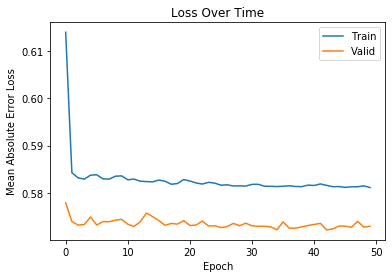

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [8]:
from tensorflow.keras.models import model_from_json

file_name = "models/baseline_nn_1"
# serialize model to JSON
model_json = model.to_json()
with open(f"{file_name}.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(f"{file_name}.h5")


In [6]:
from tensorflow.keras.models import model_from_json

file_name = "models/baseline_nn_1"
# load json and create model
json_file = open(f'{file_name}.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(f"{file_name}.h5")
print("Loaded model from disk")

Loaded model from disk


# Evaluate Sequences

In [9]:
val_generator[0][1].shape

(1024, 10, 1)

In [10]:
def predict_and_plot(model,
                     input_sequnece_batch,
                     target_sequence_batch,
                     sample_ix,
                     pred_steps: int,
                     enc_tail_len=50):
    input_sequence = input_sequnece_batch[sample_ix]
    target_sequence = target_sequence_batch[sample_ix]
    pred_series = models.predict_sequence_o2o(input_sequence,
                                              pred_steps, model)
    input_sequence = input_sequence.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_sequnece = target_sequence.reshape(pred_steps,1)
    print(target_sequence.shape)
    input_sequence_tail = np.concatenate([input_sequence[-enc_tail_len:],target_sequence[:1]])
    x_encode = input_sequence_tail.shape[0]
    
    r, p = pearsonr(pred_series.reshape(-1), target_sequence.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - target_sequence.reshape(-1)))
    print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1), input_sequence_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_sequence,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])


(10, 1)
Correlation: 0.3278058472050471. P: 0.3551383270695272. MAE: 0.6459077716159649


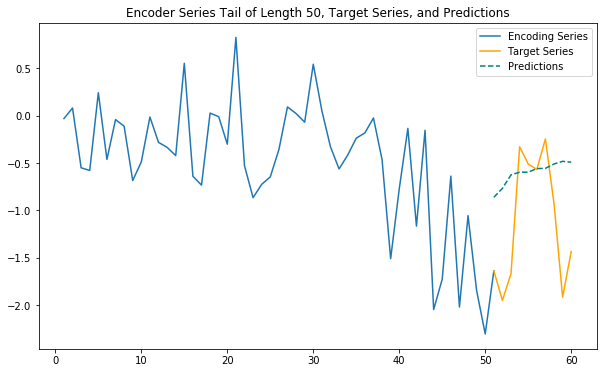

In [11]:
predict_and_plot(model, val_generator[0][0], val_generator[0][1],
                 0, pred_steps = 10)

(10, 1)
Correlation: -0.3326792129636659. P: 0.3475992049721379. MAE: 0.5832464251872758


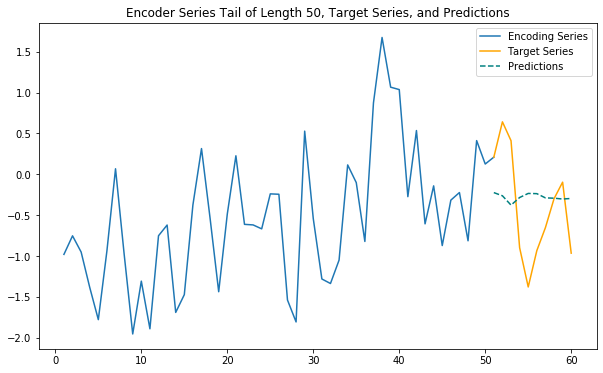

In [12]:
predict_and_plot(model, val_generator[0][0], val_generator[0][1],
                 1, pred_steps = 10)

In [13]:
def get_corr_mae(model,
                 input_sequnece_batch,
                 target_sequence_batch,
                 sample_ix,
                 pred_steps: int,
                 enc_tail_len=50,
                 verbose=True):
    input_sequence = input_sequnece_batch[sample_ix]
    target_sequence = target_sequence_batch[sample_ix]
    pred_series = models.predict_sequence_o2o(input_sequence,
                                              pred_steps, model)
    input_sequence = input_sequence.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_sequnece = target_sequence.reshape(pred_steps,1)
    input_sequence_tail = np.concatenate([input_sequence[-enc_tail_len:],target_sequence[:1]])
    x_encode = input_sequence_tail.shape[0]
    
    r, p = pearsonr(pred_series.reshape(-1), target_sequence.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - target_sequence.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    return r, mae

In [14]:
get_corr_mae(model, val_generator[0][0], val_generator[0][1],
                 1, pred_steps = 10)

Correlation: -0.3326792129636659. P: 0.3475992049721379. MAE: 0.5832464251872758


(-0.3326792129636659, 0.5832464251872758)

In [16]:
print("Calculating MAE/CORR per batch.")
batch_ix = 0
val_batch = val_generator[batch_ix] 
n_rows = val_batch[0].shape[0]//2
r_array = np.empty(shape=(n_rows,))
sample_maes = np.empty(shape=(n_rows,))
for sample_ix in range(n_rows):
    print(f"Sample: {sample_ix}/{n_rows}", end="\r")
    r, mae = get_corr_mae(model, val_batch[0], val_batch[1],
                                sample_ix=sample_ix, pred_steps=10, verbose=False)
    r_array[sample_ix] = r
    sample_maes[sample_ix] = mae
z_mean = np.mean(r_array)
batch_r = np.tanh(z_mean)
batch_mae = np.mean(sample_maes)
print(f"Batch_r: {batch_r}")
print(f"Batch Mae: {batch_mae}")

Calculating MAE/CORR per batch.
Batch_r: 0.058403083244977755
Batch Mae: 0.5629607500722925


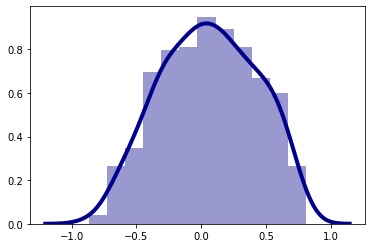

In [17]:
# Plot the distribution of r
import seaborn as sns
sns.distplot(r_array, kde=True, color = 'darkblue',
             kde_kws={'linewidth': 4})

In [17]:
k = 5
top_k_r = np.abs(r_array).argsort()[-k:]
print(top_k_r)

[36 41 20 23 14]


(10, 1)
Correlation: 0.5800871306575915. P: 0.07875493962929254. MAE: 0.6835674555174023
(10, 1)
Correlation: 0.6307199699678856. P: 0.05056012376562626. MAE: 0.8697703658963727
(10, 1)
Correlation: 0.6603577415413698. P: 0.03768570816689582. MAE: 0.6605819883031796
(10, 1)
Correlation: -0.6623229630752925. P: 0.036920063351168514. MAE: 0.4942282751608098
(10, 1)
Correlation: -0.7532753135552361. P: 0.011887942368833742. MAE: 0.54745023927397


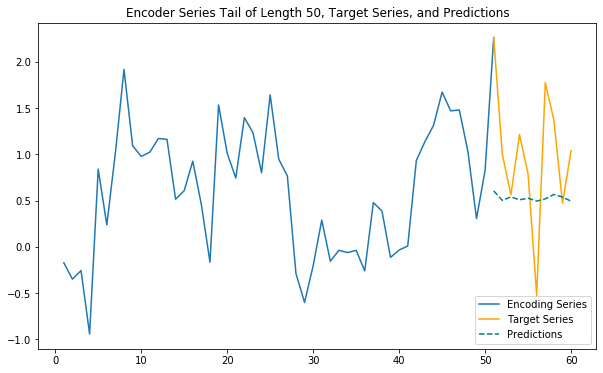

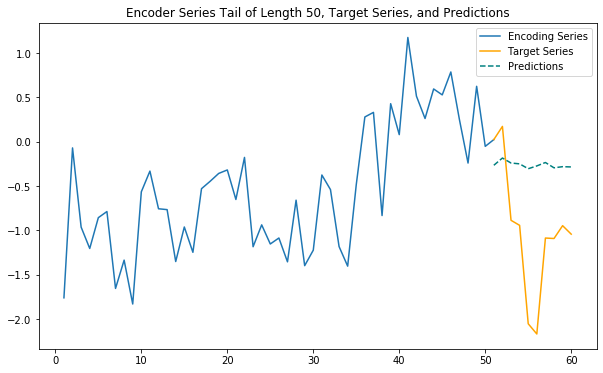

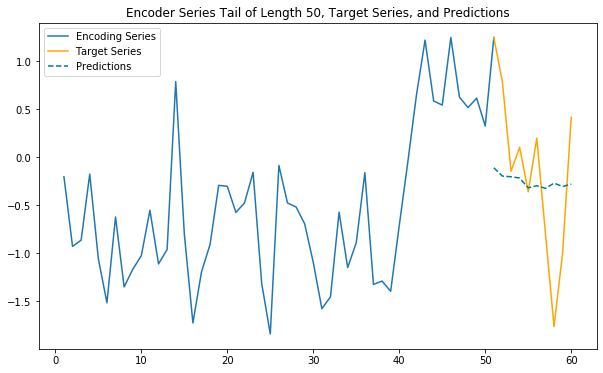

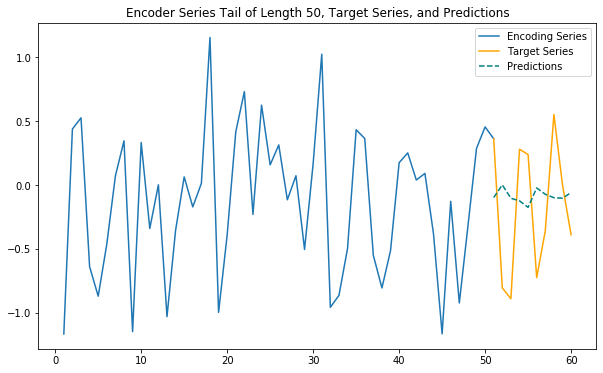

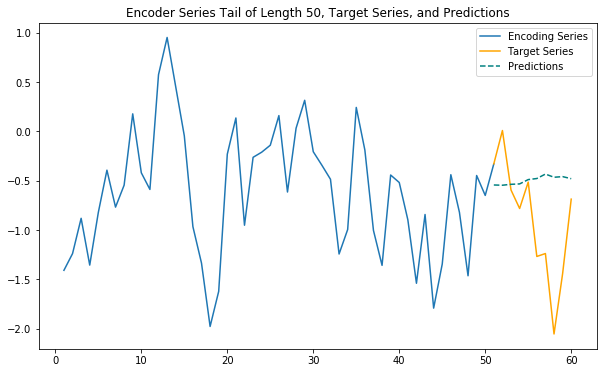

In [18]:
for i in top_k_r:
    predict_and_plot(model, val_batch[0], val_batch[1], sample_ix=i,
                     pred_steps=10)

In [19]:
k = 5
top_k_mae = sample_maes.argsort()[:k]
print(top_k_mae)

[37 34 46  9 17]


(10, 1)
Correlation: 0.4554520214910853. P: 0.1859159651248112. MAE: 0.27912857223290344
(10, 1)
Correlation: -0.1177889354965916. P: 0.7458819233638613. MAE: 0.3438357872925472
(10, 1)
Correlation: 0.4568226557550664. P: 0.1844267946920934. MAE: 0.3532121880405469
(10, 1)
Correlation: 0.3434249330420305. P: 0.33126615614357663. MAE: 0.3551341012158888
(10, 1)
Correlation: 0.3284171482278837. P: 0.35418816344989956. MAE: 0.3735453689893583


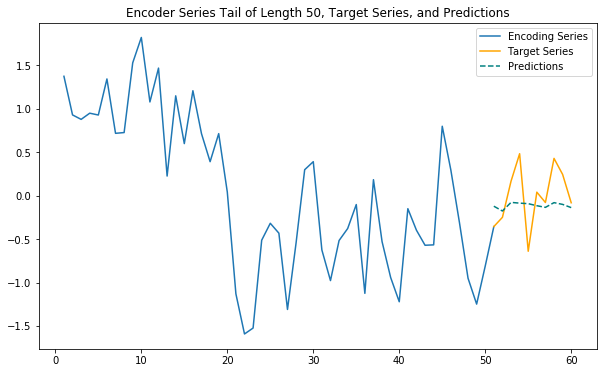

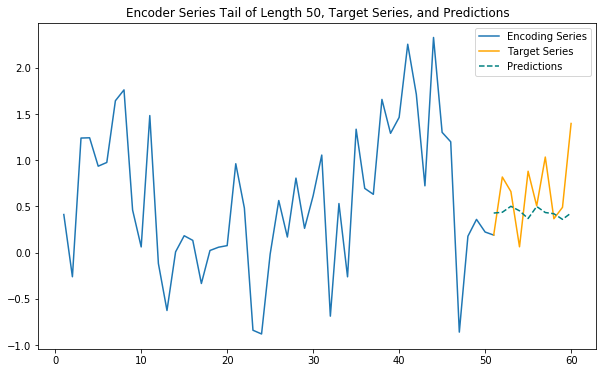

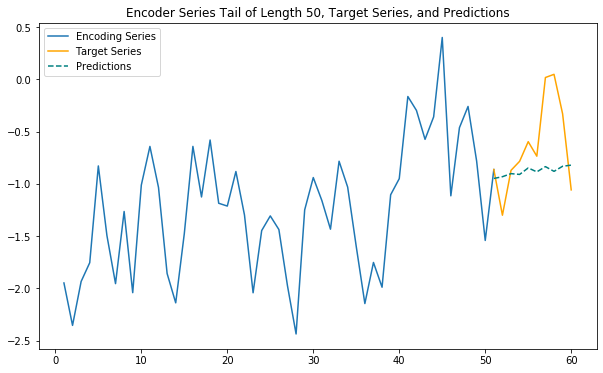

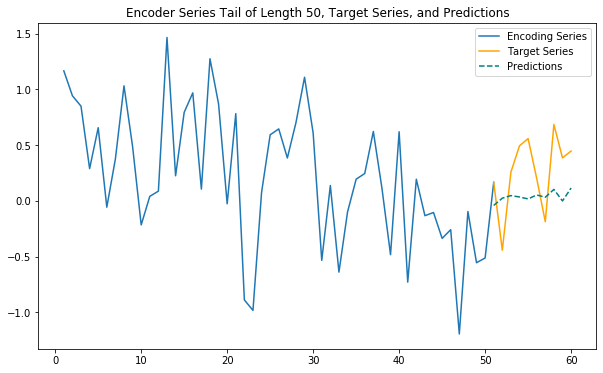

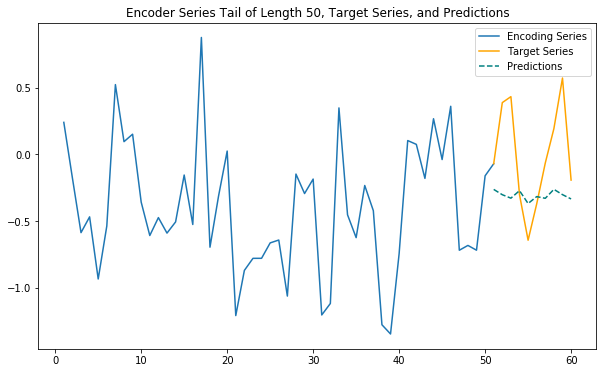

In [20]:
for i in top_k_mae:
    predict_and_plot(model, val_batch[0], val_batch[1], sample_ix=i,
                     pred_steps=10)

In [7]:
def predict_sequence_o2o_window(input_sequence, pred_steps, model, lookback=lookback):
    history_sequence = input_sequence.reshape((1, lookback, 1))
    pred_sequence = np.zeros((pred_steps,)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)
        last_step_pred = last_step_pred.reshape(-1)

        pred_sequence[i] = last_step_pred[-1]
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence[:, -(lookback-1):, :], 
                                           last_step_pred[-1].reshape(1, 1, 1)], axis=1)

    return pred_sequence

def moving_window_pred_o2o(input_sequence,
                           lookback,
                           pred_steps,
                           electrode_count,
                           model):
    # for each window of lookback predict steps and then
    # move window up by pred steps and repeat
    # window = input_sequence[w_start: w_end]
    final_array = np.empty(shape=(input_sequence.shape[0], electrode_count))
    print(final_array.shape)
    w_start = 0
    w_end = w_start + lookback
    final_array[w_start : w_end] = input_sequence[w_start : w_end]
    while w_end + pred_steps < input_sequence.shape[0]:
        window_lookback = input_sequence[w_start: w_end]
        pred_seq = predict_sequence_o2o_window(window_lookback, pred_steps, model, lookback=lookback)
        final_array[w_end:w_end+pred_steps] = pred_seq.reshape(pred_steps, electrode_count)
        w_start += pred_steps
        w_end += pred_steps
    return final_array

def get_corr_mae_conv(input_seq,
                      lookback,
                      pred_length,
                      electrode_count,
                      electrode,
                      model,
                      enc_tail_len=100,
                      verbose=True):
    
    
    input_seq = input_seq[:,electrode].reshape(input_seq.shape[0], electrode_count)

    predicted_series = moving_window_pred_o2o(input_seq,
                                              lookback = lookback,
                                              pred_steps = pred_length,
                                              electrode_count=electrode_count,
                                              model=model)
    
    input_seq = input_seq[lookback:,:]

    predicted_series = predicted_series[lookback:,:]

    input_series = input_seq.reshape(-1,1)
    pred_series = predicted_series.reshape(-1,1)   
    
    x_encode = input_series.shape[0]
    
    r, p = pearsonr(pred_series.reshape(-1), input_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - input_series.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    plt.figure(figsize=(10,6))   
    plt.plot(range(x_encode),input_series)
    plt.plot(range(x_encode),pred_series,color='orange',linestyle='--')
    plt.legend(['Input Series', 'Predictions'])
    return r, mae

def get_corr_mae_conv_step(input_seq,
                           lookback,
                           k,
                           pred_length,
                           electrode_count,
                           electrode,
                           model,
                           enc_tail_len=100,
                           verbose=True):
    
    
    input_seq = input_seq[:,electrode].reshape((input_seq.shape[0], electrode_count))

    predicted_series = moving_window_pred_o2o_step(input_seq,
                                                   lookback = lookback,
                                                   k=k,
                                                   pred_steps = pred_length,
                                                   electrode_count=electrode_count,
                                                   model=model)
    
    input_seq = input_seq[lookback:,:]

    predicted_series = predicted_series[lookback:,:]

    input_series = input_seq.reshape(-1,1)
    pred_series = predicted_series.reshape(-1,1)   
    
    x_encode = input_series.shape[0]
    
    r, p = pearsonr(pred_series.reshape(-1), input_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - input_series.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    plt.figure(figsize=(10,6))   
    plt.plot(range(x_encode),input_series)
    plt.plot(range(x_encode),pred_series,color='orange',linestyle='--')
    plt.legend(['Input Series', 'Predictions'])
    return r, mae

def moving_window_pred_o2o_step(input_sequence,
                                lookback,
                                pred_steps,
                                k,
                                electrode_count,
                                model):
    # for each window of lookback predict steps and then
    # move window up by pred steps and repeat
    # window = input_sequence[w_start: w_end]
    final_array = np.empty(shape=(input_sequence.shape[0], electrode_count))
    w_start = 0
    w_end = w_start + lookback
    final_array[w_start : w_end + k, :] = input_sequence[w_start : w_end + k, :]
    print(final_array.shape)
    full_length = int(len(input_sequence))
    print(full_length)
    i = w_end + k
    while i < full_length:
        window_lookback = np.array([input_sequence[w_start: w_end]])
#         print(window_lookback.shape)
        pred_steps = model.predict(window_lookback)
#         print(pred_steps.reshape((20, 1)))
#         print(pred_steps.shape)
        final_array[w_end + k] = pred_steps[:,k,:].reshape((1, 1))
        w_end += 1
        w_start += 1
        i += 1
    return final_array

In [8]:
val_paths = val_bin_norm_paths

In [9]:
data = np.load(val_paths[0])

(2048, 1)
Correlation: 0.5433867445366373. P: 6.972899348040016e-154. MAE: 0.589617071926676


(0.5433867445366373, 0.589617071926676)

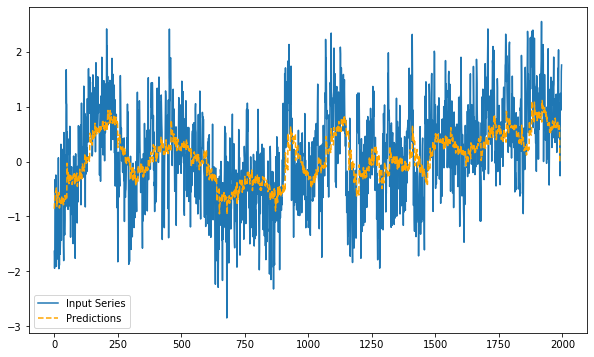

In [10]:
get_corr_mae_conv(data[:2048,:], lookback, pred_length, electrode_count=1, electrode=electrode, model=model)

(250, 1)
Correlation: 0.20214907365388413. P: 0.004096981946369042. MAE: 0.5588309211238193


(0.20214907365388413, 0.5588309211238193)

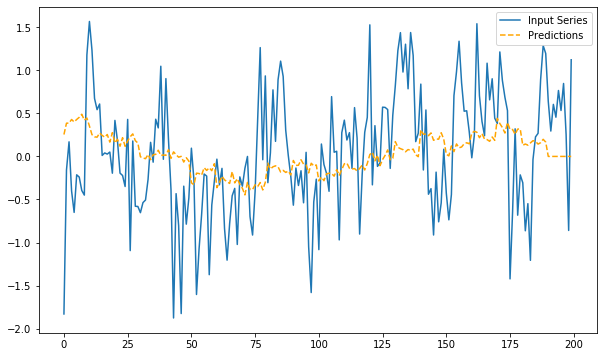

In [11]:
get_corr_mae_conv(data[250:500,:], lookback, pred_length, electrode_count=1, electrode=electrode, model=model)

(200, 1)
200
Correlation: 0.724984711895653. P: 9.720432896841228e-26. MAE: 0.48272979365649255


(0.724984711895653, 0.48272979365649255)

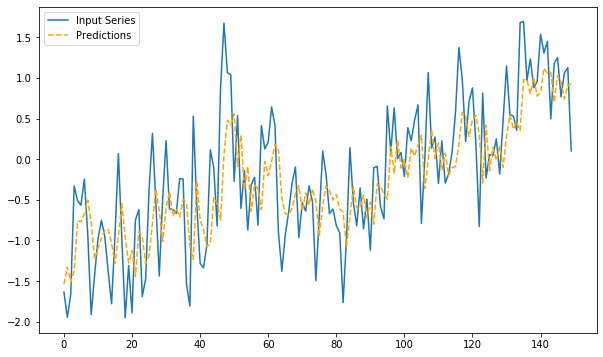

In [12]:
get_corr_mae_conv_step(data[:200,:], lookback, 0, pred_length, electrode_count=1, electrode=electrode, model=model)

(2048, 1)
2048
Correlation: 0.727353208450833. P: 0.0. MAE: 0.4779214906679847


(0.727353208450833, 0.4779214906679847)

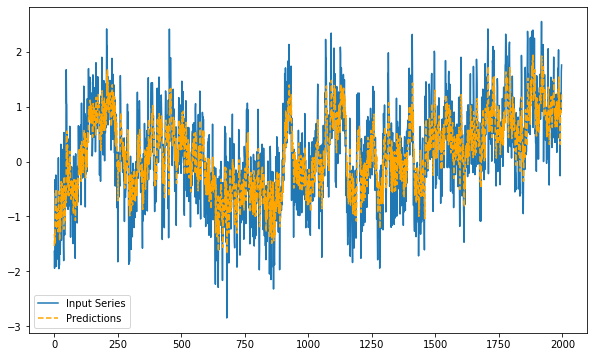

In [13]:
get_corr_mae_conv_step(data[:2048,:], lookback, 0, pred_length, electrode_count=1, electrode=electrode, model=model)

(2048, 1)
2048
Correlation: 0.5608768060747529. P: 6.103225650750256e-166. MAE: 0.5760295484510456


(0.5608768060747529, 0.5760295484510456)

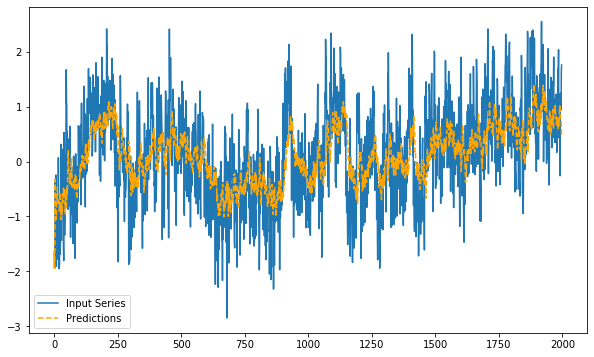

In [14]:
get_corr_mae_conv_step(data[:2048,:], lookback, 5, pred_length, electrode_count=1, electrode=electrode, model=model)

# TEST DATA

In [15]:
test_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/test_676_bin_norm_2.txt")

In [16]:
test_paths[0]

'/projects/HASSON/247/data/binned_conversations/676_bin_norm_2/bin_norm_2_NY676_618_Part5-one_conversation1/bin_norm_2_NY676_618_Part5-one_conversation1.npy'

In [17]:
for path in test_paths:
    utils.get_file_shape(path)

(163846, 114)
(102096, 114)
(73475, 114)
(33158, 114)
(17795, 114)
(64950, 114)
(92170, 114)
(83951, 114)
(42936, 114)
(21311, 114)


In [19]:
test_data = np.load(test_paths[0])

(2048, 1)
Correlation: 0.33086999093377734. P: 3.0008564101860585e-52. MAE: 0.680184117375573


(0.33086999093377734, 0.680184117375573)

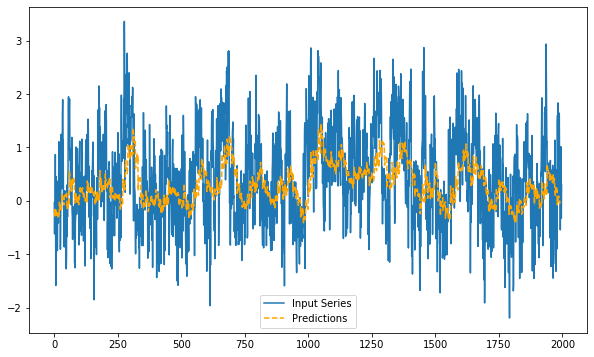

In [20]:
get_corr_mae_conv(test_data[:2048,:], lookback, pred_length, electrode_count=1, electrode=electrode, model=model)

(250, 1)
Correlation: 0.2836248800280943. P: 4.705150773738034e-05. MAE: 0.7584865235667627


(0.2836248800280943, 0.7584865235667627)

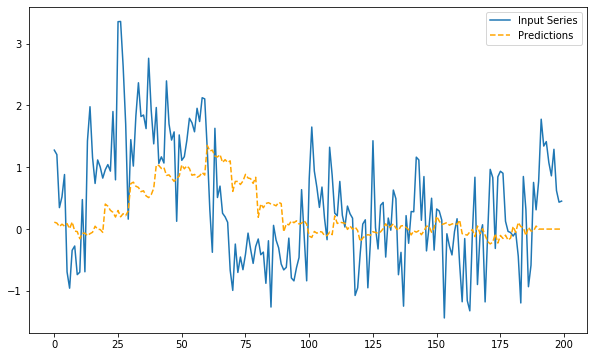

In [21]:
get_corr_mae_conv(test_data[250:500,:], lookback, pred_length, electrode_count=1, electrode=electrode, model=model)

(1100, 1)
Correlation: 0.25604828968741644. P: 3.5187922804670694e-17. MAE: 0.6941679795812606


(0.25604828968741644, 0.6941679795812606)

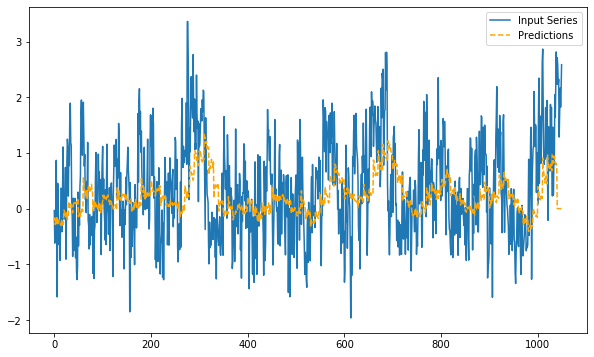

In [22]:
get_corr_mae_conv(test_data[0:1100,:], lookback, pred_length, electrode_count=1, electrode=electrode, model=model)

(200, 1)
200
Correlation: 0.5282457580504716. P: 3.726658674301859e-12. MAE: 0.5170206919758966


(0.5282457580504716, 0.5170206919758966)

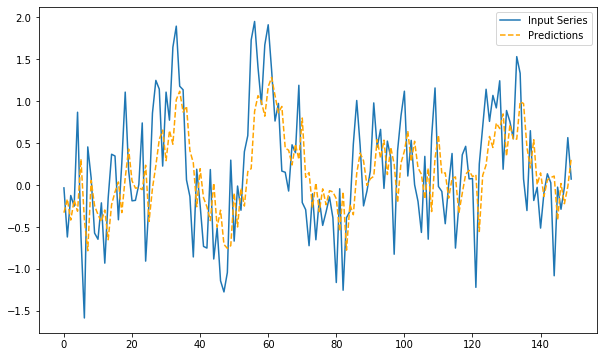

In [23]:
get_corr_mae_conv_step(test_data[:200,:], lookback, 0, pred_length, electrode_count=1, electrode=electrode, model=model)

(2048, 1)
2048
Correlation: 0.6709315324550247. P: 1.546306966465673e-261. MAE: 0.516765186055279


(0.6709315324550247, 0.516765186055279)

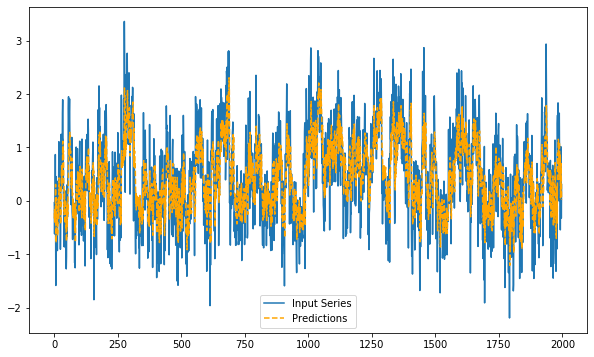

In [24]:
get_corr_mae_conv_step(test_data[:2048,:], lookback, 0, pred_length, electrode_count=1, electrode=electrode, model=model)

(2048, 1)
2048
Correlation: 0.38051958497304716. P: 7.519110133453002e-70. MAE: 0.6567066947474489


(0.38051958497304716, 0.6567066947474489)

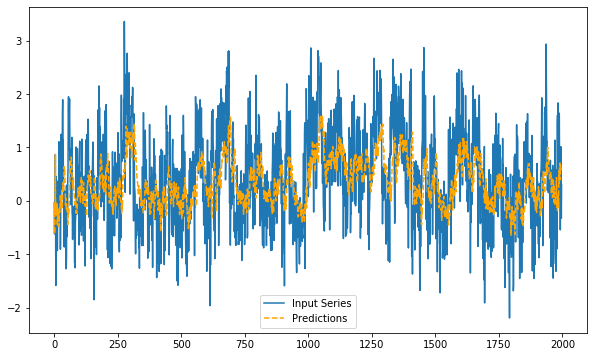

In [25]:
get_corr_mae_conv_step(test_data[:2048,:], lookback, 5, pred_length, electrode_count=1, electrode=electrode, model=model)

(1100, 1)
1100
Correlation: 0.3574980096534832. P: 5.2140069172755014e-33. MAE: 0.6627725428873383


(0.3574980096534832, 0.6627725428873383)

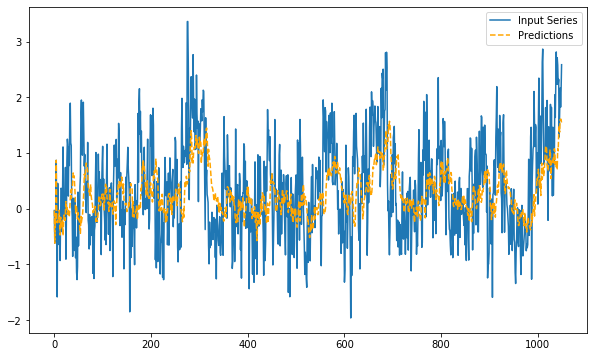

In [26]:
get_corr_mae_conv_step(test_data[:1100,:], lookback, 5, pred_length, electrode_count=1, electrode=electrode, model=model)

In [44]:
# Test_gene
test_generator = generators.FGenerator(file_paths=test_paths,
                                        lookback=lookback,
                                        length=pred_length,
                                        delay=0,
                                        batch_size=2048,
                                        sample_period=1,
                                        electrodes=[electrode],
                                        electrode_output_ix=electrode,
                                        shuffle=False)

In [45]:
len(test_generator)

2

In [46]:
test_batch = test_generator[0]

In [47]:
encoder_input_data = test_batch[0]
encoder_target_data = test_batch[1]

In [55]:
n_rows = int(encoder_input_data.shape[0]//2)
r_array = np.empty(shape=(n_rows,))
z_array = np.empty(shape=(n_rows,))
sample_maes = np.empty(shape=(n_rows,))
for sample_ix in range(n_rows):
    print(f"Sample: {sample_ix}/{n_rows}", end="\r")
    r, mae = get_corr_mae(encoder_input_data, encoder_target_data, sample_ix=sample_ix, pred_steps=20, verbose=False)
    r_array[sample_ix] = r
    z_array[sample_ix] = 0.5 * np.log((1 + r)/(1-r))
    sample_maes[sample_ix] = mae
z_mean = np.mean(z_array)
batch_r = (np.exp(2 * z_mean) - 1)/(np.exp(2 * z_mean) + 1)
batch_mae = np.mean(sample_maes)
print(f"Batch_r: {batch_r}")
print(f"Absolute Batch_r: {np.mean(np.abs(r_array))}")
print(f"Batch Mae: {batch_mae}")

Batch_r: 0.039731066407215035
Absolute Batch_r: 0.22531441950401332
Batch Mae: 0.643751233139774
